# CDR for quantum dynamics
- TFIM Hamiltonian (constants not site-dependent) evolving with TDSE
- discretize the evolution steps and use first-order Trotter decomposition 

### Idea:
- get plain CDR running for Dynamics and benchmark
- check accuracy of CDR vs runtime/step division (problem is small step division, not runtime)
- add perturbation approach (all non-Cliffords) if necessary
- add noise levels (data augmentation) if necessary



In [72]:
include("src/cpa.jl")

run_method (generic function with 1 method)

# MWE
### Exact evolution of a small trotterized circuit (see CPDR p.7)

In [50]:
nq = 9
steps = 8
T = steps/20
J =  2.0 # J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0  #abs(h) < abs(J) in ordered phase
angle_definition = pi/20
# paramagnetic (h = -2, J = 1)
#trotter = trotter_kickedising_setup(nq, steps, T, J, h);
trotter = trotter_setup(nq, steps, T, J, h);
observable= obs_interaction(trotter);
min_abs_coeff = 0.0;

In [51]:
print("sigma_h = ", trotter.sigma_h, " sigma_J = ",trotter.sigma_J,"    pi/20 = ", pi/20)

sigma_h = 0.1 sigma_J = -0.2    pi/20 = 0.15707963267948966

We see here that the `angle_definition` is smaller than the `sigma_J`value. This means that for any version of the CPA scheme, we have to replace this value by an angle within the interval. Depending on the training set generation method `sigma_h` stays as it is (loose) or is also drawn randomly from the `angle_definition` interval (strict).

### Target data

In [52]:
exact_expval_target = trotter_time_evolution(trotter; observable = observable, record=true, min_abs_coeff=min_abs_coeff,max_weight = Inf)


9-element Vector{Float64}:
 1.0
 0.990033288920621
 0.9619393455412939
 0.9207421423813666
 0.8735947972202457
 0.8282579258283804
 0.7915051528191506
 0.7678238829541896
 0.7586959066947032

In [53]:
noisy_expval_target = trotter_time_evolution(trotter; observable = observable, noise_kind="gate_ising", record=true, min_abs_coeff=min_abs_coeff)

9-element Vector{Float64}:
 1.0
 0.9510220271043257
 0.8879573890567496
 0.8172334953205904
 0.7459561445820899
 0.6804578175872463
 0.6252046032659673
 0.5822465004963527
 0.5512473100722095

In [54]:
println(noisy_expval_target)
println(typeof(noisy_expval_target))

[1.0, 0.9510220271043257, 0.8879573890567496, 0.8172334953205904, 0.7459561445820899, 0.6804578175872463, 0.6252046032659673, 0.5822465004963527, 0.5512473100722095]
Vector{Float64}


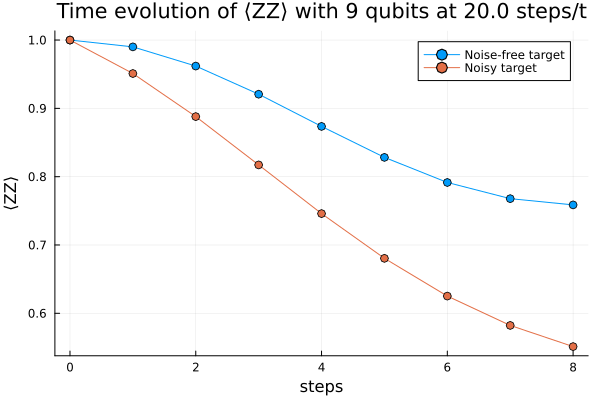

In [55]:
plot(0:trotter.steps, exact_expval_target, xlabel="steps", label="Noise-free target", marker=:o)
plot!(0:trotter.steps, noisy_expval_target, label="Noisy target", marker=:o)

if observable == obs_interaction(trotter)
    plot!(ylabel="⟨ZZ⟩", title = "Time evolution of ⟨ZZ⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
elseif observable == obs_magnetization(trotter)
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
end

### Training data

In [56]:
#list_training_thetas = training_set_generation_brut(trotter, angle_definition; num_samples=10, non_replaced_gates=30);

In [57]:
#list_training_thetas = training_set_generation_strict_perturbation(trotter;sample_function = "small",num_samples=10);

In [58]:
list_training_thetas = training_set_generation_loose_perturbation(trotter;sample_function = "small",num_samples=10);

In [59]:
exact_expvals = training_trotter_time_evolution(trotter, list_training_thetas; observable = observable, record=true);
println(size(exact_expvals))

(10,)


In [60]:
noisy_expvals = training_trotter_time_evolution(trotter, list_training_thetas; observable = observable, noise_kind="gate_ising", record = true);

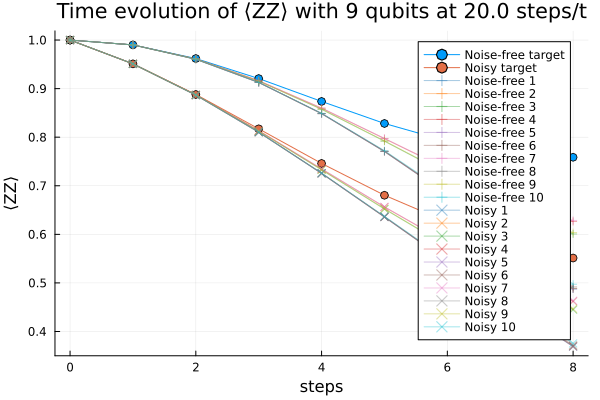

In [61]:
colors = palette(:tab10)

plot(0:trotter.steps, exact_expval_target, xlabel="steps", label="Noise-free target", marker=:o)
plot!(0:trotter.steps, noisy_expval_target, label="Noisy target", marker=:o)

for (i, exact) in enumerate(exact_expvals)
    plot!(0:trotter.steps, exact, label="Noise-free $(i)", c=colors[i], marker=:+, alpha = 0.4)
end

for (i, noisy) in enumerate(noisy_expvals)
    plot!(0:trotter.steps, noisy, label="Noisy $(i)", color=colors[i], marker=:x, alpha = 0.4)
end

if observable == obs_interaction(trotter)
    plot!(ylabel="⟨ZZ⟩", title = "Time evolution of ⟨ZZ⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
else
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
end

In [74]:
# CDR considering only last step
corrected, rel_after, rel_before = cdr(
    noisy_expvals,
    exact_expvals,
    noisy_expval_target; exact_target_exp_value = exact_expval_target, use_target=true
)
println("Corrected value: ", corrected)
println("Relative error after correction: ", rel_after)
println("Relative error before correction: ", rel_before)

#CDR with decaying weights
decay_weights = [
    [τ == t ? 1.0 : (τ == t-1 ? 0.5 : 0.0) for τ in 1:t]
    for t in 1:length(noisy_expvals[1])
]
corrected_weight, rel_after_weight, rel_before_weight = cdr(
    noisy_expvals,
    exact_expvals,
    noisy_expval_target, decay_weights; exact_target_exp_value = exact_expval_target, use_target=true
)

nsteps9
noisy_exp_values_last2[0.9510220271043257, 0.9510220271043257, 0.9510220271043257, 0.9510220271043257, 0.9510220271043257, 0.9510220271043257, 0.9510220271043257, 0.9510220271043257, 0.9510220271043257, 0.9510220271043257]
exact_exp_values_last[0.990033288920621, 0.990033288920621, 0.990033288920621, 0.990033288920621, 0.990033288920621, 0.990033288920621, 0.990033288920621, 0.990033288920621, 0.990033288920621, 0.990033288920621]
noisy_target_exp_value0.9510220271043257
exact_target_exp_value0.990033288920621
noisy_exp_values_last3[0.8866905241404276, 0.8866937845480581, 0.8871247727494642, 0.8872381101783249, 0.8866904108886571, 0.8867052668457981, 0.8872479641739633, 0.886695163959058, 0.8871370537346436, 0.8867246844424509]
exact_exp_values_last[0.9605386063223736, 0.9605422112695299, 0.9610187436052118, 0.9611440578210101, 0.9605384811028627, 0.9605549069448116, 0.9611549531249003, 0.9605437364480731, 0.9610323223677524, 0.9605763764718288]
noisy_target_exp_value0.88795738

([1.0, 0.9900332889206207, 0.9612488759715689, 0.9175887587243272, 0.8653182964856436, 0.8118985434614243, 0.7654050519757603, 0.734475479120956, 0.7250782266436789], [0.0, 3.3641990740601414e-16, 0.0007177890923428503, 0.0034248282031315094, 0.009474072832092935, 0.019751555471798604, 0.03297527596684374, 0.043432360693087764, 0.04430982130572101], [0.0, 0.03940399000000007, 0.07690916982183928, 0.11241871344464158, 0.1461073864499862, 0.17844695913209901, 0.210106717512654, 0.24169264147375952, 0.2734278579757388])

In [68]:
rel_before_weight

9-element Vector{Float64}:
 0.0
 0.03940399000000007
 0.07690916982183928
 0.11241871344464158
 0.1461073864499862
 0.17844695913209901
 0.210106717512654
 0.24169264147375952
 0.2734278579757388

### Correction over time (standard CDR vs. weighted linear regression)

In [69]:
plot(1:trotter.steps, rel_before[2:end-1], xlabel="steps", label="rel. error before correction", marker=:o)
plot!(1:trotter.steps, rel_after[2:end-1], label="rel. error after correction (LR)", marker=:o)
plot!(1:trotter.steps, rel_after_weight[2:end-1], label="rel. error after correction (weighted LR)", marker=:o, yscale=:log10,legend=:best)

## ZNE + CDR

### ZNE method isolated

In [16]:
# test 
noisy_exp_target_level = zne_time_evolution(trotter; observable = observable, noise_kind="gate_ising", record = true);
println(size(noisy_exp_target_level))

(3, 12)


### Extrapolate to the zero noise level
- use only final value for now
- we could use cdr function immediately but use a new one to avoid confusion

In [17]:
noisy_exp_last = [row[end] for row in noisy_exp_target]

UndefVarError: UndefVarError: `noisy_exp_target` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [18]:
print(typeof(noisy_exp_target))

UndefVarError: UndefVarError: `noisy_exp_target` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

- 2 methods, correct every step or only last

noise_levels = [1,1.2,1.5]

In [19]:
corrected = zne_fit(noisy_exp_last; exact_target_exp_value = exact_expval_target[end], use_target = true)

UndefVarError: UndefVarError: `zne_fit` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## vnCDR implementation

see Piotr 2021 for vnCDR implementation steps
-  for each circuit from the training data, calculate expectation value at multiple noise levels ( e.g 1,1.2,1.5) and the corresponding noiseless expectation value
- vnCDR works with the varied noise levels of the training circuits, while ZNE works with the varied noise levels of the target circuit (implemented above)
- CPDR-ZNE described in the CPA paper is the same idea as vnCDR, but they allow for small angle perturbation from Cliffords and the use a Ridge Regression to reduce overfitting
- implement: vnCDR, which natively extends to CPDR -ZNE with linear regression
- add ridge regression as an option (self implemented, convex.jl, LinearRegressionKit.jl)

In [20]:
# test
noisy_expvals = vnCDR_training_trotter_time_evolution(trotter, list_training_thetas; observable = observable, noise_kind="gate_ising", record = true)

Noisy expval at noise level 1.0: [[1.0, 0.9510220271043257, 0.8867724497274669, 0.8108028027031379, 0.7269094561489937, 0.6389020151929673, 0.5503975258591172, 0.46464966919039863, 0.3844188329697526, 0.3118856976616772, 0.2486079702722818, 0.1955173109187029], [1.0, 0.9510220271043257, 0.8867128511346156, 0.8104711066281062, 0.7258920226026596, 0.6365809088153056, 0.5459875095288919, 0.4572666647204399, 0.3731688039382607, 0.2959619370437804, 0.2273850868874543, 0.1686316010896154], [1.0, 0.9510220271043257, 0.8867318616556583, 0.8105769956156361, 0.7262171900663654, 0.6373237962306421, 0.5474014444990133, 0.4596386703560965, 0.37679172595067206, 0.3011035574839387, 0.23425783265827202, 0.17736607438198854], [1.0, 0.9510220271043257, 0.8872384066810791, 0.8133688305088895, 0.7346654775723599, 0.6562665563619305, 0.5826448821763469, 0.5172096999883232, 0.4620914503259709, 0.4181105500815832, 0.3849066377575496, 0.36118702691163374], [1.0, 0.9510220271043257, 0.8866831950547418, 0.81030

3×10×12 Array{Float64, 3}:
[:, :, 1] =
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

[:, :, 2] =
 0.951022  0.951022  0.951022  0.951022  …  0.951022  0.951022  0.951022
 0.931955  0.931955  0.931955  0.931955     0.931955  0.931955  0.931955
 0.913175  0.913175  0.913175  0.913175     0.913175  0.913175  0.913175

[:, :, 3] =
 0.886772  0.886713  0.886732  0.887238  …  0.886917  0.886816  0.88669
 0.85174   0.851684  0.851702  0.852183     0.851878  0.851782  0.851662
 0.817923  0.817869  0.817886  0.818344     0.818053  0.817962  0.817848

;;; … 

[:, :, 10] =
 0.311886  0.295962  0.301104  0.418111  …  0.348125  0.323112  0.289738
 0.266611  0.253894  0.258     0.351579     0.29557   0.275579  0.248925
 0.227434  0.217286  0.220562  0.295345     0.250556  0.234592  0.213322

[:, :, 11] =
 0.248608  0.227385  0.234258  0.384907  …  0.296191  0.263457  0.21904
 0.210274  0.193696  

In [21]:
## noisy_target_exp_value for zne, also do plain zne in the meanwhile


In [22]:
noisy_expvals_end = noisy_expvals[:,:,end]

3×10 Matrix{Float64}:
 0.195517  0.168632  0.177366  0.361187  …  0.254821  0.214173  0.157991
 0.163849  0.143286  0.149965  0.290903     0.209252  0.178124  0.135151
 0.136812  0.121106  0.126207  0.234134     0.171529  0.147722  0.114895

In [23]:
exact_expvals_end = [row[end] for row in exact_expvals]

10-element Vector{Float64}:
 0.27525554697641774
 0.229485212198801
 0.2443603060483396
 0.5558447584144051
 0.20575365489305186
 0.4369069496653706
 0.3225520031775273
 0.3760179771520719
 0.3069848760811085
 0.21135677569926142

In [24]:
print(typeof(exact_expval_target))

Vector{Float64}

In [25]:
pred, rel_after, rel_before = vnCDR(
    noisy_expvals_end,
    exact_expvals_end,
    noisy_exp_last; exact_target_exp_value = exact_expval_target[end], use_target=true, lambda = 0.0
)

UndefVarError: UndefVarError: `noisy_exp_last` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

### vnCDR after every step

In [26]:
#2nd method: vnCDR for every step
function vnCDR(
    noisy_exp_values::Array{Float64,3},        # size (n+1 noise levels, m circuits, t+1 steps)
    exact_exp_values::Vector{Vector{Float64}},        
    noisy_target_exp_value::Vector{Vector{Float64}}; 
    exact_target_exp_value::Union{Nothing, Vector{Float64}}=nothing,
    use_target::Bool=true,
    lambda::Float64=0.0
)
    println("size exact_exp_vals ",size(exact_exp_values))
    nsteps = size(noisy_exp_values, 3)

    println("nsteps" , nsteps)
    corrected = Vector{Float64}(undef, nsteps)
    rel_errors_after = Float64[] ##!
    rel_errors_before = Float64[] ##!
    for i in 1:nsteps
        println("size 1 ",size(transpose(noisy_exp_values[:, :, i])))
    
        println("type of noisy_exp_values[:,:,i]",typeof(noisy_exp_values[:, :, i]))
        println(typeof(exact_exp_values[i]))
        println(typeof(noisy_target_exp_value[i]))
        println(typeof(exact_target_exp_value[i]))
        # result = vnCDR(
        #     permutedims(noisy_exp_values[:, :, i]),                     # extract (n+1, m) slice
        #     exact_exp_values[i],
        #     noisy_target_exp_value[i];
        #     exact_target_exp_value = use_target ? (exact_target_exp_value === nothing ? nothing : exact_target_exp_value[i]) : nothing,
        #     use_target = use_target,
        #     lambda = lambda
        # )

        println("perm ",size(permutedims(noisy_exp_values[:, :, i], (2, 1))))
        result = vnCDR(
        permutedims(noisy_exp_values[:, :, i], (2, 1)),
        exact_exp_values[i],
        noisy_target_exp_value[i];
        exact_target_exp_value = use_target ? (exact_target_exp_value === nothing ? nothing : exact_target_exp_value[i]) : nothing,
        use_target = use_target,
        lambda = lambda
    )

        

        if use_target && exact_target_exp_value !== nothing
            corrected[i], err_after, err_before = result
            push!(rel_errors_after, err_after)
            push!(rel_errors_before, err_before)
        else
            corrected[i] = result
        end
    end

    return use_target ? (corrected, rel_errors_after, rel_errors_before) : corrected
end


vnCDR (generic function with 2 methods)

In [27]:
#test 
println("noisy_expvals ", size(noisy_expvals)) #(3,10,8)
println("exact_expvals ", size(exact_expvals)) #(10,8)
println("noisy_expval_target ", size(noisy_expval_target)) #()
println("exact_expval_target ", size(exact_expval_target))

corr, rel_after, rel_before = vnCDR(
    noisy_expvals,
    exact_expvals,
    noisy_exp_target; exact_target_exp_value = exact_expval_target, use_target=true
)

noisy_expvals (3, 10, 12)
exact_expvals (10,)
noisy_expval_target (12,)
exact_expval_target (12,)


UndefVarError: UndefVarError: `noisy_exp_target` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

# CDR tests

### Full Run Test

In [28]:
#now full run is set to the loose method
global_logger(UnbufferedLogger(stdout, MainInfo))

nq = 9
steps = 5
sigma_star = pi/20
T = 0.2
J = 2.0 #J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0 #abs(h) < abs(J) in ordered phase
trotter = trotter_setup(nq, steps, T, J, h);
noise_kind = "gate_ising" #takes the default gate values
min_abs_coeff = 1e-10; #training set (exact and noisy)
min_abs_coeff_exact = 0.0 #this should be 0 to get
min_abs_coeff_noisy = min_abs_coeff;
observable  = obs_interaction(trotter) #propagate doesn't like PauliStrings for some reason

#observable = PauliString(nq, :Z, 5) #obs_interaction(trotter); #obs_magnetization(trotter);
#training_set = training_set_generation_loose_perturbation(trotter, sigma_star; sample_function = "CPA", num_samples=10);
#training_set = training_set_generation_brut(trotter, sigma_star; num_samples=10, non_replaced_gates=30);
exact_expval_target, noisy_expval_target, corr_energy, rel_error_before, rel_error_after = full_run(trotter, sigma_star, noise_kind; min_abs_coeff,max_weight = 8, min_abs_coeff_noisy, observable = observable, record = true, cdr_method = "end", use_target = false, real_qc_noisy_data = 1e-3)

(NaN, 0.001, 0.01715072816257418, NaN, NaN)

### CDR weight assignment test

In [29]:
#now full run is set to the loose method
global_logger(UnbufferedLogger(stdout, MainInfo))

nq = 9
steps = 7
sigma_star = pi/20
T = 0.25
J = 2.0 #J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0 #abs(h) < abs(J) in ordered phase
trotter = trotter_setup(nq, steps, T, J, h);
cdr_methods = ["std_LR", "lin_WLR", "last1_WLR"]
rel_after_list = Vector{Vector{Float64}}()
for cdr_method in cdr_methods
    noise_kind ="gate_ising" #takes the default gate values
    min_abs_coeff = 0.0 #1e-10; #traiing set (exact and noisy)#this should be 0 to get
    min_abs_coeff_noisy = min_abs_coeff;
    training_set = training_set_generation_loose_perturbation(trotter, sigma_star; sample_function = "small", num_samples=10);
    #training_set = training_set_generation_brut(trotter, sigma_star; num_samples=10, non_replaced_gates=30);
    #we can make this more efficient by not recalc the "exact" expvals
    exact_expval_target, noisy_expval_target, corr_energy, rel_error_before, rel_error_after = full_run(trotter, sigma_star, noise_kind; min_abs_coeff, min_abs_coeff_noisy, training_set, observable = obs_magnetization(trotter),record = true, cdr_method = cdr_method)
    # add to dataframe each time (only rel_error_after, with cdr_method label)
    rel_error_after = rel_error_after[2:end] #remove the first one, as it is not corrected
    rel_after_list = push!(rel_after_list, rel_error_after)
    #then add once the rel_error_before
end

InterruptException: InterruptException:

In [30]:
print("sigma_h = ", trotter.sigma_h, " sigma_J = ",trotter.sigma_J,"    pi/20 = ", pi/20)

sigma_h = 0.07142857142857142 sigma_J = -0.14285714285714285    pi/20 = 0.15707963267948966

In [31]:
plot(1:trotter.steps, rel_before[2:end], xlabel="steps", label="rel. error before correction", marker=:o,title = "CDR method comparison")
plot!(1:trotter.steps, rel_after_list[1], label="rel. error after correction (std_LR)", marker=:o)
plot!(1:trotter.steps, rel_after_list[2], label="rel. error after correction (lin_WLR)", marker=:o)
plot!(1:trotter.steps, rel_after_list[3], label="rel. error after correction (last1_WLR)", marker=:o)
plot!(yscale=:log10,legend=:bottomright)

UndefVarError: UndefVarError: `rel_before` not defined in `Main`
Suggestion: check for spelling errors or missing imports.